<a href="https://colab.research.google.com/github/daj10/TPE-Brain-Tumour-Segmentation/blob/master/BraST_2019_SANON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BraTS - brain tumors segmentation**

> Multi class Image Segmentation. The data is 3D MRI images with 4 channels

*   Flair
*   T1
*   T1ce
*   T2

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

##**All libraries**  

In [ ]:
!pip install SimpleITK

In [ ]:
import sys
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.pylab as pylab
import numpy as np

#**Functions for visualization** 

In [ ]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
#-----------------------------------------------------------

def show_n_images(imgs, titles = None, enlarge = 20, cmap='jet'):
    
    plt.set_cmap(cmap)
    n = len(imgs)
    gs1 = gridspec.GridSpec(1, n)   
    
    fig1 = plt.figure(); # create a figure with the default size 
    fig1.set_size_inches(enlarge, 2*enlarge);
            
    for i in range(n):

        ax1 = fig1.add_subplot(gs1[i]) 

        ax1.imshow(imgs[i], interpolation='none');
        if (titles is not None):
            ax1.set_title(titles[i])
        ax1.set_ylim(ax1.get_ylim()[::-1])

    plt.show();
#--------------------------------------------------------------
from skimage import io, color, img_as_float
from skimage.exposure import adjust_gamma

# Creates an image of original brain with segmentation overlay
def show_lable_on_image(test_img, test_lbl):

        modes = {'flair':0, 't1':1, 't1c':2, 't2':3}

        label_im = test_lbl
        
        ones = np.argwhere(label_im == 1)
        twos = np.argwhere(label_im == 2)
        threes = np.argwhere(label_im == 3)
        fours = np.argwhere(label_im == 4)

        gray_img = img_as_float(test_img/test_img.max())

        # adjust gamma of image
        image = adjust_gamma(color.gray2rgb(gray_img), 0.45)
        #sliced_image = image.copy()

        red_multiplier = [1, 0.2, 0.2]
        green_multiplier = [0.35,0.75,0.25]
        blue_multiplier = [0,0.5,1.]#[0,0.25,0.9]
        yellow_multiplier = [1,1,0.25]
        brown_miltiplier = [40./255, 26./255, 13./255]
   

        # change colors of segmented classes
        for i in range(len(ones)):
            image[ones[i][0]][ones[i][1]] = blue_multiplier#red_multiplier
        for i in range(len(twos)):
            image[twos[i][0]][twos[i][1]] = yellow_multiplier 
        for i in range(len(threes)):
            image[threes[i][0]][threes[i][1]] = brown_miltiplier#blue_multiplier
        for i in range(len(fours)):
            image[fours[i][0]][fours[i][1]] = green_multiplier#yellow_multiplier

        return image
#-------------------------------------------------------------------------------------
def show_lable_on_image4(test_img, label_im):
        
    alpha = 0.8

    img = img_as_float(test_img/test_img.max())
    rows, cols = img.shape

    # Construct a colour image to superimpose
    color_mask = np.zeros((rows, cols, 3))
    red_multiplier = [1, 0.2, 0.2]
    green_multiplier = [0.35,0.75,0.25]
    blue_multiplier = [0,0.25,0.9]
    yellow_multiplier = [1,1,0.25]
    brown_miltiplier = [40./255, 26./255, 13./255]
    
        
    color_mask[label_im==1] = blue_multiplier#[1, 0, 0]  # Red block
    color_mask[label_im==2] = yellow_multiplier#[0, 1, 0] # Green block
    color_mask[label_im==3] = brown_miltiplier#[0, 0, 1] # Blue block
    color_mask[label_im==4] = green_multiplier#[0, 1, 1] # Blue block

    # Construct RGB version of grey-level image
    img_color = np.dstack((img, img, img))

    # Convert the input image and color mask to Hue Saturation Value (HSV)
    # colorspace
    img_hsv = color.rgb2hsv(img_color)
    color_mask_hsv = color.rgb2hsv(color_mask)

    # Replace the hue and saturation of the original image
    # with that of the color mask
    img_hsv[..., 0] = color_mask_hsv[..., 0]
    img_hsv[..., 1] = color_mask_hsv[..., 1] * alpha

    img_masked = color.hsv2rgb(img_hsv)

    return img_masked
#------------------------------------------------------------------------------
# DL visualizations

def drow_history(history):
    
    # list all data in history
    if (not type(history)==dict):
        history=history.history
    print(history.keys())
    plt.figure(figsize=(7,4))
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def drow_loss(history):
    
    # list all data in history
    if (not type(history)==dict):
        history=history.history

    print(history.keys())
    plt.figure(figsize=(6,5))
    plt.plot(history['lr'], history['loss'])
    plt.plot(history['lr'], history['val_loss'])
    plt.title('model loss by learning rate')
    plt.ylabel('loss')
    plt.xlabel('learning rate')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def append_history(history1, history2):
    
    if (type(history1)==dict):
        if (not type(history2)==dict):
            history2 = history2.history
            for key in history1:
                history1[key] = history1[key] + history2[key]
            return history1
    
    if (not type(history1)==dict):
        if (type(history2)==dict):
            
            for key in history1.history:
                history1.history[key] = history1.history[key] + history2[key]
            return history1
        
    for key in history1.history:
        history1.history[key] = history1.history[key] + history2.history[key]
    return history1

# **Data Preprocessing**


#N4BiasFieldCorrectionImageFilter : on train and validationdata



> Before applying the transformation, each patient's folder contains 5 types of images. for example for this patient 
 *BraTS19_TCIA04_192_1* we have : 

*   BraTS19_TCIA04_192_1_flair.nii.gz 
*   BraTS19_TCIA04_192_1_t1.nii.gz 
*   BraTS19_TCIA04_192_1_t2.nii.gz
*   BraTS19_TCIA04_192_1_seg.nii.gz 
*   BraTS19_TCIA04_192_1_t1ce.nii.gz 
  

> After apply the filter the files below will be added to the folder.
*   BraTS19_TCIA09_141_1_t1_nb4.nii.gz
*   BraTS19_TCIA09_141_1_t1ce.nii.gz

In [ ]:
DATA= '/content/drive/My Drive/MICCAI_BraTS_2019_Data_Training/'
DATA_HGG = DATA +'HGG/'
DATA_LGG = DATA + 'LGG/'

FLAIR = 'flair'
T1 = 't1'
T2 = 't2'
T1CE = 't1ce'

In [ ]:
import os, sys, glob
import numpy as np
import SimpleITK as sitk
import sys
import os
import pandas as pd
import re
import pandas
import numpy



> **N4 bias field correction** algorithm for correcting low frequency intensity non-uniformity present in MRI image data known as a bias or gain field.the primary input is required to have a “real” pixel type of either sitkFloat32 or sitkFloat64


> **OtsuThreshold**: Threshold of an image using the Otsu threshold


> *Otsu's method is used to perform automatic thresholding from the histogram shape of image, or the reduction of a grayscale image to a binary image. The algorithm then assumes that the image to be binarized contains only two classes of pixels, (i.e. foreground and background) and then calculates the optimal threshold that separates these two classes so that their intra-class variance is minimal.*





In [ ]:
def n4cor(in_img, out_img):
    inputImage = sitk.ReadImage(in_img )
    maskImage = sitk.OtsuThreshold( inputImage, 0, 1, 200 )

    inputImage = sitk.Cast( inputImage, sitk.sitkFloat32 )
    corrector = sitk.N4BiasFieldCorrectionImageFilter();
    numberFilltingLevels = 4

    output = corrector.Execute( inputImage, maskImage ) 
    sitk.WriteImage( output, out_img )

> find all relevant image directories

In [ ]:
input_path = DATA_HGG
        
hgg_paths = []
for dirpath, dirnames, files in os.walk(input_path):
    for dir in dirnames:
        if ('BraTS19' in dir):
            hgg_paths.append(dir)

input_path = DATA_LGG
        
lgg_paths = []
for dirpath, dirnames, files in os.walk(input_path):
    for dir in dirnames:
        if ('BraTS19' in dir):
            lgg_paths.append(dir)

In [ ]:
len(lgg_paths),len(hgg_paths)

(76, 259)

> N4 bias field correction filter on T1 and T1CE images on Train data

In [ ]:
%%time

for dirpath, dirnames, files in os.walk(input_path):

    for file in files:
        if ('_t1.' in file):
            in_img = os.path.join(dirpath, file)
            out_img = os.path.join(dirpath, file[:-9]+ 't1_nb4.nii.gz')
            print(in_img, out_img)
            if (not os.path.isfile(out_img)):
                n4cor(in_img, out_img)
        
        if (T1CE in file):
            in_img = os.path.join(dirpath, file)
            out_img = os.path.join(dirpath,file[:-11]+ 't1ce_nb4.nii.gz')
            print(in_img, out_img)
            if (not os.path.isfile(out_img)):
                n4cor(in_img, out_img)



> N4 bias field correction filter on T1 and T1CE images on validation data



In [ ]:
VALIDATION_DATA = '/content/drive/My Drive/MICCAI_BraTS_2019_Data_Validation/'

In [ ]:
VALIDATION_DATA

In [ ]:
%%time

for dirpath, dirnames, files in os.walk(VALIDATION_DATA):

    for file in files:
        if ('_t1.' in file):
            in_img = os.path.join(dirpath, file)
            out_img = os.path.join(dirpath, file[:-9]+ 't1_nb4.nii.gz')
            if (not os.path.isfile(out_img)):
                print(in_img, out_img)
                n4cor(in_img, out_img)
        
        if (T1CE in file):
            in_img = os.path.join(dirpath, file)
            out_img = os.path.join(dirpath,file[:-11]+ 't1ce_nb4.nii.gz')
            if (not os.path.isfile(out_img)):
                print(in_img, out_img)
                n4cor(in_img, out_img)

# **Load Nifty (.nii.gz) data and convert to numpy**

> Remember that each forder contain 5 differents modalities of images And we have 4 labels.


In [ ]:
DATA= '/content/drive/My Drive/MICCAI_BraTS_2019_Data_Training/'
VALIDATION_DATA = '/content/drive/My Drive/MICCAI_BraTS_2019_Data_Validation/'
DATA_HGG = DATA +'HGG/'
DATA_LGG = DATA + 'LGG/'



> Numpy data directories



In [ ]:
NUMPY_DIR = '/content/drive/My Drive/MICCAI_BraTS_2019_Data_Training/train_numpy_images/'
VALIDATION_NUMPY_DIR = '/content/drive/My Drive/MICCAI_BraTS_2019_Data_Validation/validation_numpy_images/'

In [ ]:
FLAIR = 'flair'
T1 = 't1'
T2 = 't2'
T1CE = 't1ce'

In [ ]:
img_type=['FLAIR', 'T1','T1CE', 'T2']

In [ ]:
import os, sys, glob
import numpy as np
import SimpleITK as sitk
import sys
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.utils import shuffle
%matplotlib inline

In [ ]:
from skimage.util.dtype import dtype_range
from skimage.util import img_as_ubyte
from skimage import exposure
from skimage.morphology import disk
from skimage.filters import rank
from scipy.ndimage import gaussian_filter
from skimage import data
from skimage import img_as_float
from skimage.morphology import reconstruction
from scipy import ndimage
import random

## Data utilities Functions


> GetArrayFromImage: Get a numpy array from a SimpleITK Image.



In [ ]:
def read_img_sitk(img):
    inputImage = sitk.ReadImage( img )
    inputImage = sitk.Cast( inputImage, sitk.sitkFloat32 )
    image = sitk.GetArrayFromImage(inputImage)
    return image

### Convert and merge images, flair, t1, t2, t1ce

In [ ]:
def read_image_into_numpy(dirpath):
    
    img_id = os.path.basename(dirpath)
    np_image=np.zeros((4, 155, 240, 240), dtype=np.float32)
    
    ## Flair
    flair_img = os.path.join(dirpath, img_id+'_flair.nii.gz')
    if (not os.path.isfile(flair_img)):
        print(flair_img,' not found aborting')
        return None
    np_image[0] = read_img_sitk(flair_img)
        
    ## T1
    t1_nb4_img = os.path.join(dirpath, img_id+'_t1_nb4.nii.gz')
    if (not os.path.isfile(t1_nb4_img)):
        #print(t1_nb4_img,' not found')
        t1_img = os.path.join(dirpath, img_id+'_t1.nii.gz')
        if (not os.path.isfile(t1_img)):
            print(t1_img,' not found aborting')
            return None
        np_image[1] = read_img_sitk(t1_img)
    else:
        np_image[1] = read_img_sitk(t1_nb4_img)    
            
    ## T1CE
    t1ce_nb4_img = os.path.join(dirpath, img_id+'_t1ce_nb4.nii.gz')
    if (not os.path.isfile(t1ce_nb4_img)):
        #print(t1ce_nb4_img,' not found')
        t1ce_img = os.path.join(dirpath, img_id+'_t1ce.nii.gz')
        if (not os.path.isfile(t1ce_img)):
            print(t1ce_img,' not found aborting')
            return None
        np_image[2] = read_img_sitk(t1ce_img)
    else:
        np_image[2] = read_img_sitk(t1ce_nb4_img)    
    
        
    ## T2
    t2_img = os.path.join(dirpath, img_id+'_t2.nii.gz')
    if (not os.path.isfile(t2_img)):
        print(t2_img,' not found aborting')
        return None
    np_image[3] = read_img_sitk(t2_img)

    return np_image



> Get label into files already labeled ( .seg files )



In [ ]:
def read_lable_into_numpy(dirpath):
    
    img_id = os.path.basename(dirpath)
    np_image=np.zeros((155, 240, 240), dtype=np.int)
    
    ## lable
    lable_img = os.path.join(dirpath, img_id+'_seg.nii.gz')
    if (not os.path.isfile(lable_img)):
        print(lable_img,' not found aborting')
        return None
    np_image = read_img_sitk(lable_img).astype(int)

    return np_image


## Load data and Collect train data info

In [ ]:
hgg_paths = []
for dirpath, dirnames, files in os.walk(DATA_HGG):
    if ('BraTS19' in dirpath):
        hgg_paths.append(dirpath)

lgg_paths = []
for dirpath, dirnames, files in os.walk(DATA_LGG):
    if ('BraTS19' in dirpath):
        lgg_paths.append(dirpath)
        
val_paths = []
for dirpath, dirnames, files in os.walk(VALIDATION_DATA):
    if ('BraTS19' in dirpath):
        val_paths.append(dirpath)

In [ ]:
len(lgg_paths),len(hgg_paths),len(val_paths)

(76, 259, 125)

In [ ]:
def bbox2_3D(img):

    r = np.any(img, axis=(1, 2))
    c = np.any(img, axis=(0, 2))
    z = np.any(img, axis=(0, 1))

    rmin, rmax = np.where(r)[0][[0, -1]]
    cmin, cmax = np.where(c)[0][[0, -1]]
    zmin, zmax = np.where(z)[0][[0, -1]]

    return [rmin, rmax, cmin, cmax, zmin, zmax]

## View some data

In [ ]:
np_img = read_image_into_numpy('/content/drive/My Drive/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_TCIA04_192_1')

In [ ]:
show_n_images(np_img[:,100,:,:], titles=img_type)
plt.savefig('les_modalites.png')

In [ ]:
np_lbl = read_lable_into_numpy('/content/drive/My Drive/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_TCIA04_192_1')

In [ ]:
img1 = show_lable_on_image4(np_img[1,100,:,:], np_lbl[100])
img2 = show_lable_on_image(np_img[1,100,:,:], np_lbl[100])
show_n_images([img1,img2,np_img[0,100]])

# Read all images collect data and save as numpy



> There are 259 images in train data, each has segmentation labeling file, with the following labels:

*   Label 0: background
*   Label 1: necrotic and non-enhancing tumor
*   Label 2: edema
*   Label 4: enhancing tumor In the data preprocessing stage

> I converted and merged the nii.gz files, to a numpy file of the format: (155, 240, 240, 4)

> For simplicity, I change label 4 to 3. So we need to change it back, for submitting results to Brats challange.

> Lables are 1, 2 and 4. So we will save 4 as 3. Don't forget to set it back to 4 before submission to Brats.









In [ ]:
label_type_shrt = ['background', 'necrotic',
             'edema', 'enhancing']

label_type = ['background', 'necrotic and non-enhancing tumor', 'edema', 'enhancing tumor']

*   **Rmin** - Lowest row number to retain
*   **Cmin** - Lowest column number to retain

In [ ]:
df = pd.DataFrame(columns=['Grade','id','lab0','lab1','lab2','lab3',
                           'rmin','rmax','cmin','cmax','zmin','zmax'])


In [ ]:
def fill_df_from_path(df, paths = hgg_paths, grade='HGG'):
    
    for f in paths:
        np_img = read_image_into_numpy(f)
        np_lbl = read_lable_into_numpy(f)
        assert(np_lbl[np_lbl==3].sum()==0)
        np_lbl = np.where(np_lbl==4, 3, np_lbl)
        #new
        new_img = np.zeros((155, 240, 240,4))
        for i in range(4):
            new_img[:,:,:,i] = np_img[i, :,:,:] 
            
        nimg = os.path.join(NUMPY_DIR, os.path.basename(f)+'.npy')
        np.save(nimg, new_img)
        nlbl = os.path.join(NUMPY_DIR, os.path.basename(f)+'_lbl.npy')
        np.save(nlbl, np_lbl)

        lbls, repeats = np.unique(np_lbl, return_counts=True)
        lbl_counts=[0,0,0,0]
        for i in range(len(repeats)):
            lbl_counts[lbls[i]] = repeats[i]
        

        vals = [grade] + [os.path.basename(f)] + lbl_counts + bbox2_3D(np_lbl)
        
        df.loc[len(df)] = vals
        
    return df

In [ ]:
df = fill_df_from_path(df, paths = lgg_paths, grade='LGG')


In [ ]:
df = fill_df_from_path(df, paths = hgg_paths)

In [ ]:
df.shape

(335, 12)

In [ ]:
df[['lab' +str(i) for i in range(1,4)]].sum()

lab1    0.0
lab2    0.0
lab3    0.0
dtype: float64

In [ ]:

6260157.0*100/(7566423.0+19290531.0+6260157.0)

18.903089100978644

In [ ]:
df[['lab' +str(i) for i in range(1,4)]].sum().plot(kind='bar', color=my_colors,
                                                   title='Lable distribution')


## Read, Collect and save data for validation data

> Of course the validation folder doesn't contain labeled files.



In [ ]:
df_val = pd.DataFrame(columns=['id','lab0','lab1','lab2','lab3'])

In [ ]:
def fill_df_from_path(df=df_val, paths = val_paths):
    
    for f in paths:
        np_img = read_image_into_numpy(f)

        new_img = np.zeros((155, 240, 240,4))
        for i in range(4):
            new_img[:,:,:,i] = np_img[i, :,:,:] 

        nimg = os.path.join(VALIDATION_NUMPY_DIR,  os.path.basename(f)+'.npy')
        np.save(nimg, new_img)
        
        vals = [os.path.basename(f)]+[0,0,0,0]
        df.loc[len(df)] = vals
        
    return df

In [ ]:
df_val = fill_df_from_path(df_val, paths = val_paths)

# **Split data to train-test and save it as a csv file**

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2)

In [ ]:
df_train.to_csv('/content/drive/My Drive/df_train.csv', index=False)
df_test.to_csv('/content/drive/My Drive/df_test.csv',index=False)
df_val.to_csv('/content/drive/My Drive/df_val.csv' ,index=False)

# **Unet for multi-class segmentation**

>  Train and predict



In [ ]:
import os, sys, glob
import numpy as np
import SimpleITK as sitk
import sys
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.utils import shuffle


import pandas
import numpy

from skimage.util.dtype import dtype_range
from skimage.util import img_as_ubyte
from skimage import exposure
from skimage.morphology import disk
from skimage.filters import rank
from scipy.ndimage import gaussian_filter
from skimage import data
from skimage import img_as_float
from skimage.morphology import reconstruction
from scipy import ndimage
import random
from random import randrange

%matplotlib inline

### Read image description files

> Above, all files were saved as numpy.

> Label data was collected to assist in the training phase.

In [ ]:
df_train= pd.read_csv('/content/drive/My Drive/df_train.csv')
df_test= pd.read_csv('/content/drive/My Drive/df_test.csv')
df_val= pd.read_csv('/content/drive/My Drive/df_val.csv')

In [ ]:
df_train

,Grade,id,lab0,lab1,lab2,lab3,rmin,rmax,cmin,cmax,zmin,zmax
0,HGG,BraTS19_TCIA03_121_1,8817790,4749,76402,29059,39,98,90,170,56,115
1,HGG,BraTS19_2013_23_1,8780214,51737,23689,72360,46,117,51,130,108,178
2,HGG,BraTS19_CBICA_ABE_1,8788770,19827,94456,24947,59,134,53,152,104,176
3,LGG,BraTS19_TCIA10_202_1,8780213,94173,53582,32,33,110,57,182,62,132
4,LGG,BraTS19_TCIA13_642_1,8739314,168606,11325,8755,54,130,117,207,116,184
...,...,...,...,...,...,...,...,...,...,...,...,...
263,HGG,BraTS19_CBICA_ARZ_1,8908850,402,17336,1412,70,134,82,142,83,137
264,HGG,BraTS19_CBICA_ALN_1,8872870,4603,44753,5774,42,114,115,183,132,191
265,HGG,BraTS19_CBICA_ANP_1,8882882,341,43082,1695,48,103,115,193,75,154
266,HGG,BraTS19_CBICA_AOO_1,8859882,12416,37481,18221,55,131,87,151,99,164


In [ ]:
df_test

,Grade,id,lab0,lab1,lab2,lab3,rmin,rmax,cmin,cmax,zmin,zmax
0,HGG,BraTS19_CBICA_AVF_1,8792748,47184,58053,30015,42,110,91,185,49,115
1,HGG,BraTS19_TCIA01_448_1,8847231,8969,54524,17276,35,94,87,165,108,173
2,LGG,BraTS19_TCIA13_633_1,8566217,189152,171595,1036,30,131,42,154,58,161
3,HGG,BraTS19_TCIA02_608_1,8830788,18024,50981,28207,32,103,136,206,120,179
4,HGG,BraTS19_CBICA_AAP_1,8824504,10902,77096,15498,54,121,123,201,125,180
...,...,...,...,...,...,...,...,...,...,...,...,...
62,HGG,BraTS19_CBICA_AYC_1,8758315,22889,110884,35912,34,113,89,210,50,123
63,LGG,BraTS19_TCIA13_650_1,8910918,9634,7323,125,15,49,136,173,98,132
64,HGG,BraTS19_CBICA_BIC_1,8776715,4073,115349,31863,72,138,88,194,63,124
65,HGG,BraTS19_TCIA02_473_1,8904544,319,18041,5096,43,93,94,149,65,105


In [ ]:
df_val

,id,lab0,lab1,lab2,lab3
0,BraTS19_CBICA_APM_1,0,0,0,0
1,BraTS19_TCIA02_457_1,0,0,0,0
2,BraTS19_TCIA10_631_1,0,0,0,0
3,BraTS19_TCIA02_294_1,0,0,0,0
4,BraTS19_UAB_3446_1,0,0,0,0
...,...,...,...,...,...
120,BraTS19_TCIA13_643_1,0,0,0,0
121,BraTS19_MDA_1012_1,0,0,0,0
122,BraTS19_CBICA_BHN_1,0,0,0,0
123,BraTS19_MDA_907_1,0,0,0,0


In [ ]:
red_multiplier = [1, 0.2, 0.2]
green_multiplier = [0.35,0.75,0.25]
blue_multiplier = [0,0.5,1.] #[0,0.25,0.9]
yellow_multiplier = [1,1,0.25]
brown_miltiplier = [40./255, 26./255, 13./255]
my_colors=[blue_multiplier, yellow_multiplier, brown_miltiplier]

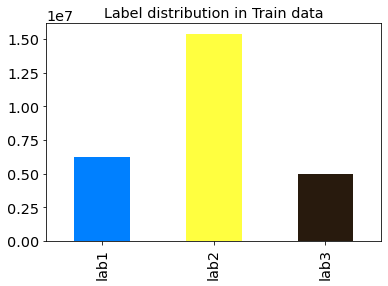

In [ ]:
df_train[['lab' +str(i) for i in range(1,4)]].sum().plot(kind='bar', color=my_colors,
                                                   title='Label distribution in Train data')
plt.savefig('Label_distribution_Train.png')

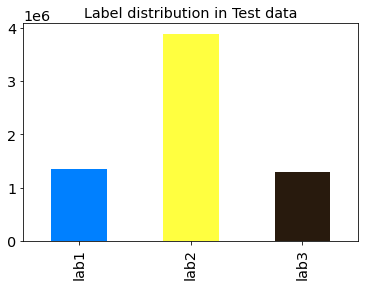

In [ ]:

df_test[['lab' +str(i) for i in range(1,4)]].sum().plot(kind='bar', color=my_colors,
                                                   title='Label distribution in Test data')
plt.savefig('Label_distribution_Test.png')

### others Visualization utilities

In [ ]:
def show_img_lable(img, lbl, modality = 0):
    
    if (len(lbl.shape)> 2):
        lbl[0,0,3]=1 # for uniqe colors in plot
        lbl = lbl_from_cat(lbl)
    show_n_images([img[:,:,modality],lbl, show_lable_on_image4(img[:,:,modality],lbl)],
                    titles = [img_type[modality], 'Label', 'Label on '+ img_type[modality]]);

In [ ]:
def show_lable(lbl):
    
    show_n_images([lbl[:,:,k] for k in range(4)]+[lbl_from_cat(lbl)],
                 titles = label_type_shrt + ['Label'])

In [ ]:
def show_pred_im_lable(im, lb, pred):
    
    show_n_images([im[:,:,1], lb[:,:], 
                   show_lable_on_image4(im[:,:,1], lb[:,:]),
                  show_lable_on_image4(im[:,:,1], pred[:,:])],
                 titles=['Flair', 'Label', 'Label on T1', 'Prediction on Flair'])

In [ ]:
def show_pred_im(im, pred):
    
    show_n_images([im[:,:,1], 
                   im[:,:,0],pred,
                  show_lable_on_image4(im[:,:,1], pred[:,:])],
                 titles=['Flair','T1', 'Pred',  'Prediction on Flair'])

## **Build Train generator**

In [ ]:
from random import randrange
from keras.utils import np_utils


> Get images and its labels


In [ ]:
def get_numpy_img_lbl(img_id = 'BraTS19_TCIA10_449_1', np_dir=NUMPY_DIR):
    img=np.load(os.path.join(np_dir, img_id+'.npy'))
    lbl=np.load(os.path.join(np_dir, img_id+'_lbl.npy'))
    return img,lbl

In [ ]:
def get_random_img(axis=0, df=df_train, np_dir=NUMPY_DIR):
    
    ind = randrange(len(df))
    img_id= df.iloc[ind].id
    img,lbl = get_numpy_img_lbl(img_id, np_dir=NUMPY_DIR)
        
    if (axis==0):
        x = randrange(df.iloc[ind].rmin, df.iloc[ind].rmax+1)
        return img[ x,:,:, :], lbl[x,:,:]

    im = np.zeros((240,240,4),dtype=np.float32)    
    lb = np.zeros((240,240),dtype=np.int)
        
    if (axis==1):
        y = randrange(df.iloc[ind].cmin, df.iloc[ind].cmax+1)
        im[40:40+155,:,:]=img[:, y,:, :]
        lb[40:40+155,:]=lbl[:, y,:]
        return im,lb
    
    if (axis == 2):
        z = randrange(df.iloc[ind].zmin, df.iloc[ind].zmax+1)
        im[40:40+155,:,:]=img[:,:, z, :]
        lb[40:40+155,:]=lbl[:,:,z]
        return im,lb
    return None

<Figure size 432x288 with 0 Axes>

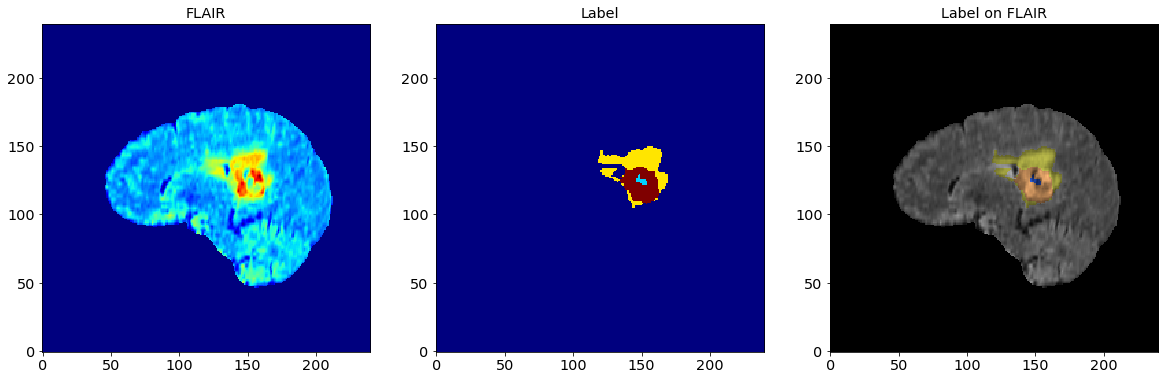

In [ ]:
img,lbl = get_random_img(2)
show_img_lable(img, lbl)

### Function randomly selects a 2D image that includes the given label

In [ ]:
def get_img_for_label(lab=2, axis=0, df=df_train,np_dir = NUMPY_DIR):
    
    img_id= random.choice(df[df['lab'+str(lab)] > 0].id.values)
    
    img,lbl = get_numpy_img_lbl(img_id, np_dir)
    ind = np.where(lbl==lab)
    k = random.randrange(len(ind[0]))
    
    if (axis==0):        
        return img[ind[0][k],:,:] , lbl[ind[0][k],:,:]
        
    lb = np.zeros((240,240),dtype=np.int)
    im = np.zeros((240,240,4),dtype=np.float32)
    
    if (axis==1):
        im[40:40+155,:,:]=img[:, ind[1][k],:,:]
        lb[40:40+155,:]=lbl[:, ind[1][k],:]
        return im,lb
    
    if (axis == 2):
        im[40:40+155,:,:]=img[:, :, ind[2][k],:]
        lb[40:40+155,:]=lbl[:,:,ind[2][k]]
        return im,lb
    return None

In [ ]:
img,lbl = get_img_for_label(1,1)
show_img_lable(img, lbl)
plt.savefig('img_label_axis1.png')

In [ ]:
img,lbl = get_img_for_label(3,0)
show_img_lable(img, lbl)
plt.savefig('img_label_axis0.png')

In [ ]:
img,lbl = get_img_for_label(2,2)
show_img_lable(img, lbl)
plt.savefig('img_label_AXIS2.png')

In [ ]:
img,lbl = get_img_for_label(1,0)
show_img_lable(img, lbl)

In [ ]:
def lbl_from_cat(cat_lbl):
    
    lbl=0
    if (len(cat_lbl.shape)==3):
        for i in range(1,4):
            lbl = lbl + cat_lbl[:,:,i]*i
    elif (len(cat_lbl.shape)==4):
        for i in range(1,4):
            lbl = lbl + cat_lbl[:,:,:,i]*i
    else:
        print('Error in lbl_from_cat', cat_lbl.shape)
        return None
    return lbl

### For test we will create batch from few test images. only planes with lables >0 will be included.

In [ ]:
def normalize_3D_image(img):
    for z in range(img.shape[0]):
        for k in range(4):
            if (img[z,:,:,k].max()>0):
                img[z,:,:,k] /= img[z,:,:,k].max()
    return img

In [ ]:
def normalize_2D_image(img):

        for c in range(4):
            if (img[:,:,c].max()>0):
                img[:,:,c] = img[:,:,c]/img[:,:,c].max()
        return img

### Function returns all z-planes of the image that have non-zerolable

In [ ]:
def get_img_batch(row, np_dir=NUMPY_DIR):
    
    im,lb = get_numpy_img_lbl(row['id'], np_dir)
    
    n_im = row['rmax']-row['rmin']
    rmin=row['rmin']
    rmax=row['rmax']
    
    return normalize_3D_image(im[rmin:rmax]), np_utils.to_categorical(lb[rmin:rmax],4)

<Figure size 432x288 with 0 Axes>

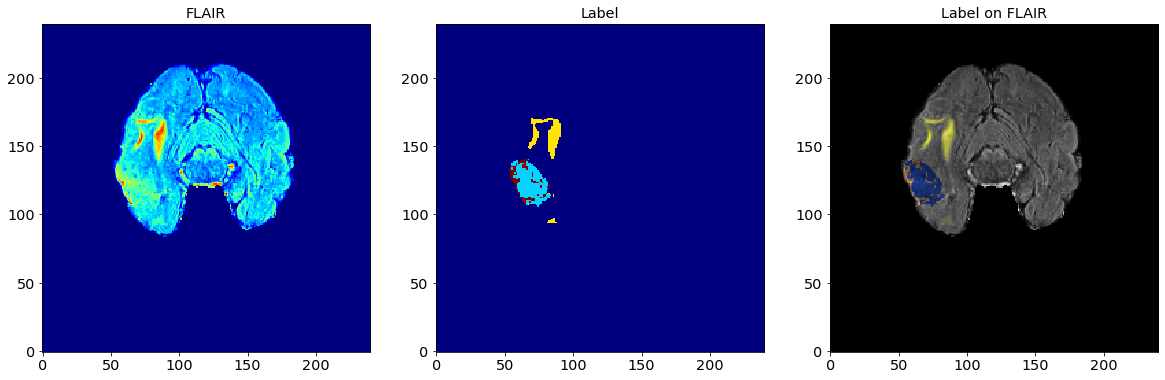

In [ ]:
im, lb = get_img_batch(df_test.iloc[0])
im.shape, lb.shape
show_img_lable(im[6], lb[6])

<Figure size 432x288 with 0 Axes>

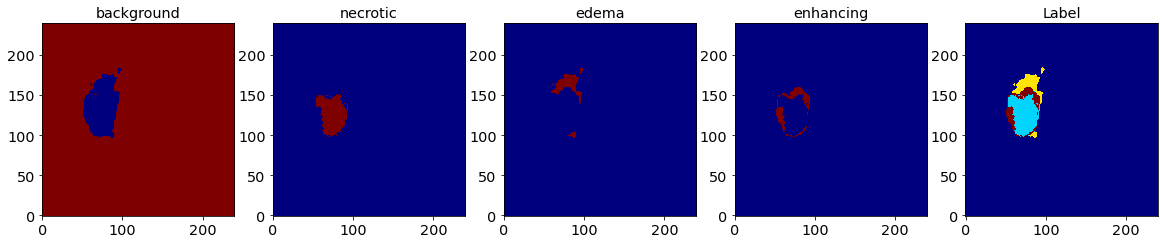

<Figure size 432x288 with 0 Axes>

In [ ]:
i=15
show_lable(lb[i])
plt.savefig('appercu_labels.png')

### Get images with non-zero labels from all raws of given data frame

In [ ]:
def get_df_img_batch(df_batch, np_dir=NUMPY_DIR):
    
        n_images = (df_batch.rmax - df_batch.rmin).sum()
        b_images = np.zeros((n_images, 240, 240, 4), np.float32)
        b_label = np.zeros((n_images, 240, 240, 4), np.int8)    
        ind=0
        for index, row in df_batch.iterrows():
 
            b_im, b_lb = get_img_batch(row, np_dir)
            n_im = b_im.shape[0]
            b_images[ind:ind+n_im] = b_im
            b_label[ind:ind+n_im] = b_lb
            ind+=n_im
               
        return b_images, b_label

<Figure size 432x288 with 0 Axes>

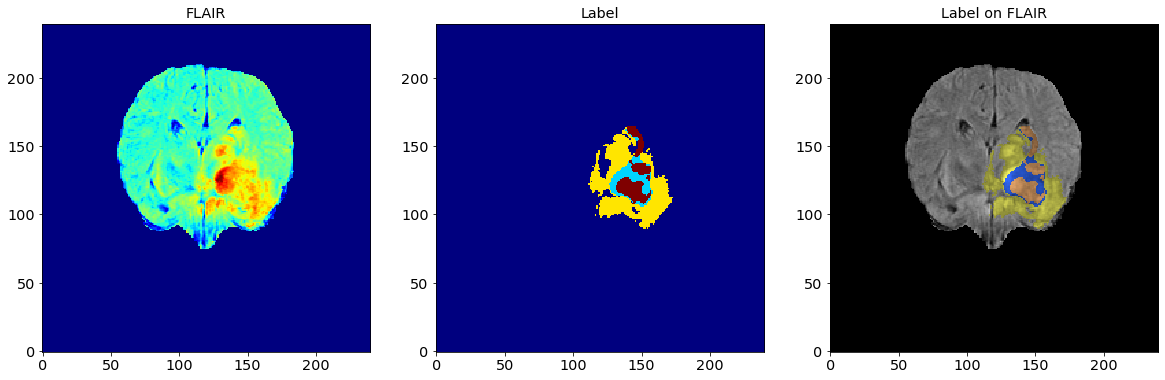

In [ ]:
im, lb = get_df_img_batch(df_test.iloc[0:3])
show_img_lable(im[100],lb[100])

### Generator for test images

> 3 images, ~251 planes



In [ ]:
def generate_im_test_batch(n_images = 3, batch_size=300, df = df_test, np_dir=NUMPY_DIR):

    while True:
         
        df_batch = df.sample(n_images)
        b_images, b_label = get_df_img_batch(df_batch, np_dir)                    
        b_images, b_label = shuffle(b_images, b_label)
        if (batch_size > 0):
            b_images = b_images[0:batch_size]
            b_label = b_label[0:batch_size]
            
        yield b_images, b_label

In [ ]:
%%time
gen_test_im = generate_im_test_batch(5)
imtest,lbtest = next(gen_test_im)
imtest.shape, lbtest.shape

CPU times: user 938 ms, sys: 919 ms, total: 1.86 s
Wall time: 24 s


<Figure size 432x288 with 0 Axes>

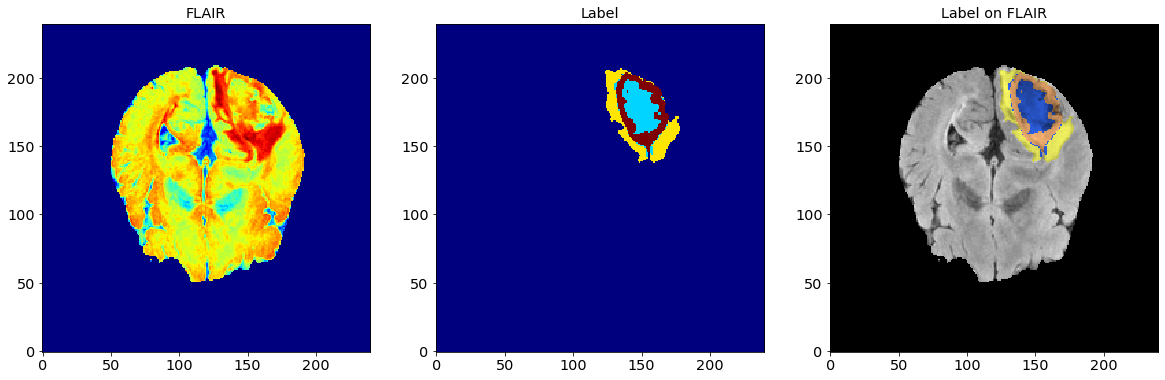

<Figure size 432x288 with 0 Axes>

In [ ]:
show_img_lable(imtest[100], lbtest[100])
plt.savefig('label_flair.png')

<Figure size 432x288 with 0 Axes>

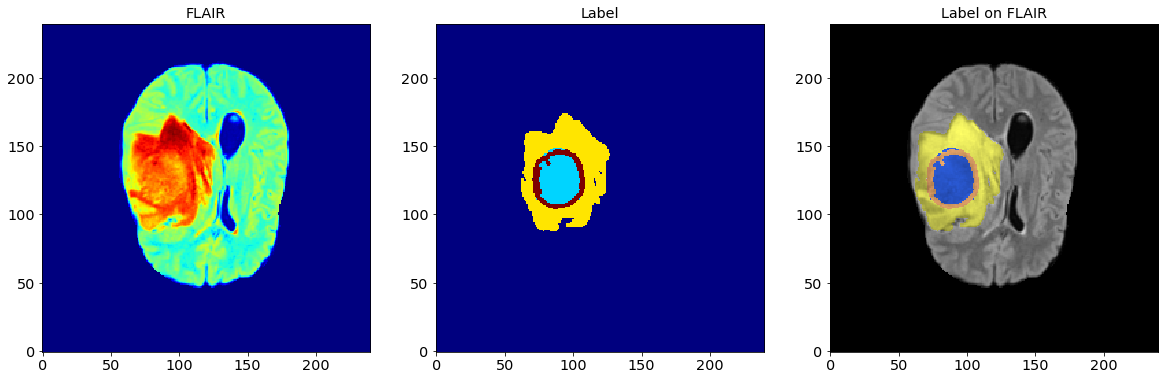

<Figure size 432x288 with 0 Axes>

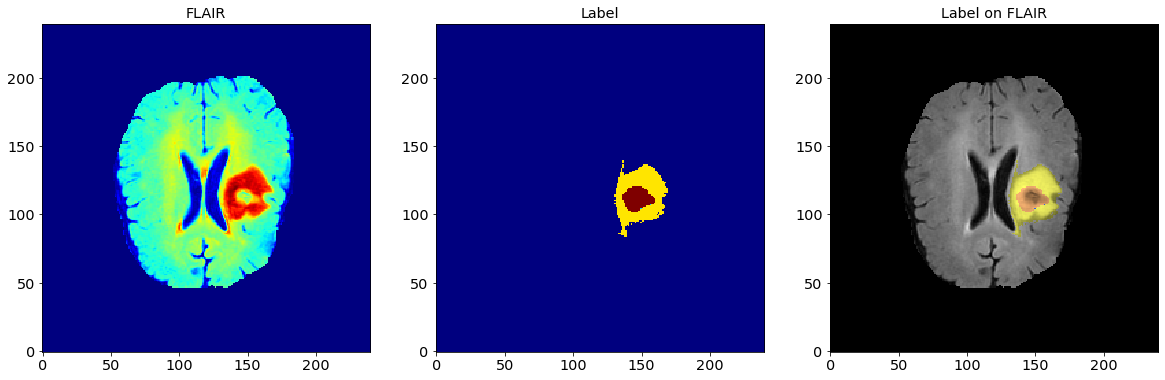

<Figure size 432x288 with 0 Axes>

In [ ]:
ind=[6,8]
for i in ind:show_img_lable(imtest[i], lbtest[i])
plt.savefig('label_flair2.png')

### Test the faster generator.


> for 32 batch size



In [ ]:
def generate_faste_train_batch(batch_size = 12, df = df_train ,np_dir=NUMPY_DIR):
    
    batch_images = np.zeros((batch_size, 240, 240, 4), np.float32)
    batch_label = np.zeros((batch_size, 240, 240, 4), np.int8)    
    
    # lab1 22%
    # lab2 58%
    # lab3 18%

    while True:
        
        df_batch = df.sample(3)
        b_images, b_label = get_df_img_batch(df_batch, np_dir)                    
        b_images, b_label = shuffle(b_images, b_label)
        batch_images[0:batch_size//2]=b_images[0:batch_size//2]
        batch_label[0:batch_size//2]=b_label[0:batch_size//2]
        
        i=batch_size//2
        # lab 1
        nim = batch_size//4
        for j in range(nim):
            im,lbl = get_img_for_label(lab=1, axis=random.choice([0,1,2]), df=df)
            batch_images[i] = normalize_2D_image(im)
            batch_label[i] = np_utils.to_categorical(lbl, 4)
            i+=1
                        
        # lab 3
        nim = batch_size//4
        for j in range(nim):
            im,lbl = get_img_for_label(lab=3, axis=random.choice([0,1,2]), df=df)
            batch_images[i] = normalize_2D_image(im)
            batch_label[i] = np_utils.to_categorical(lbl, 4)
            i+=1

        batch_images, batch_label = shuffle(batch_images, batch_label)
            
        yield batch_images, batch_label

In [ ]:
%%time
gen_train_fast = generate_faste_train_batch(batch_size=16)
bimg,blbl = next(gen_train_fast)
bimg.shape, blbl.shape

CPU times: user 1.05 s, sys: 2.17 s, total: 3.22 s
Wall time: 1min 15s


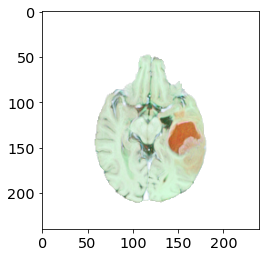

In [ ]:
plt.imshow(normalize_2D_image(bimg[8]))

### Slower train batch, but more ballanced in labels

> Define train generator and test that it works correctly.

In [ ]:
#***

def generate_train_batch(batch_size = 12, df = df_train):
    
    batch_images = np.zeros((batch_size, 240, 240, 4), np.float32)
    batch_label = np.zeros((batch_size, 240, 240, 1), np.int8)    
    
    # lab1 22%
    # lab2 58%
    # lab3 18%

    while 1:
         
        i = 0
        
        # lab 1
        nim = batch_size//4
        for j in range(nim):
            im,lbl = get_img_for_label(lab=1, axis=random.choice([0,1,2]), df=df)
            batch_images[i] = im/im.max()
            batch_label[i,:,:,0] = lbl
            i+=1
            
        
        # lab 2
        nim = batch_size//2
        for j in range(nim):
            im,lbl = get_img_for_label(lab=2, axis=random.choice([0,1,2]), df=df)
            batch_images[i] = im/im.max()
            batch_label[i,:,:,0] = lbl
            i+=1
            
        # lab 3
        nim = batch_size//4
        for j in range(nim):
            im,lbl = get_img_for_label(lab=3, axis=random.choice([0,1,2]), df=df)
            batch_images[i] = im/im.max()
            batch_label[i,:,:,0] = lbl
            i+=1

        # The rest
        nim = batch_size - i
        for j in range(nim):
            im,lbl = get_random_img(axis=random.choice([0,1,2]), df=df)
            batch_images[i] = im/im.max()
            batch_label[i,:,:,0] = lbl
            i+=1
                    
        batch_images, batch_label = shuffle(batch_images, batch_label)
            
        yield batch_images, np_utils.to_categorical(batch_label, 4)

In [ ]:
%%time
gen_train = generate_train_batch(batch_size=16)
bimg,blbl = next(gen_train)
bimg.shape, blbl.shape

CPU times: user 722 ms, sys: 2.99 s, total: 3.72 s
Wall time: 1min 54s


<Figure size 432x288 with 0 Axes>

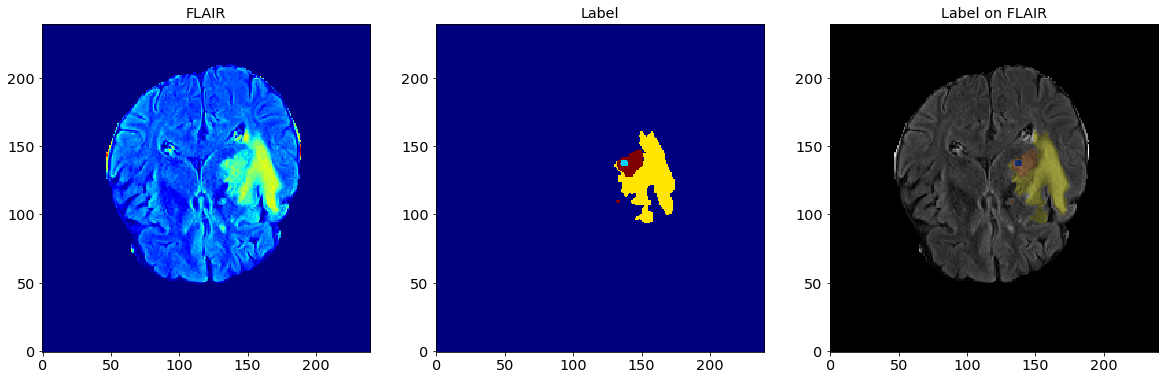

In [ ]:
show_img_lable(bimg[i], blbl[i])

### Test the generator


In [ ]:
%%time
gen_test = generate_train_batch(36,df_test)
bimg,blbl = next(gen_test)
bimg.shape, blbl.shape

CPU times: user 1.33 s, sys: 8.04 s, total: 9.37 s
Wall time: 4min 25s


<Figure size 432x288 with 0 Axes>

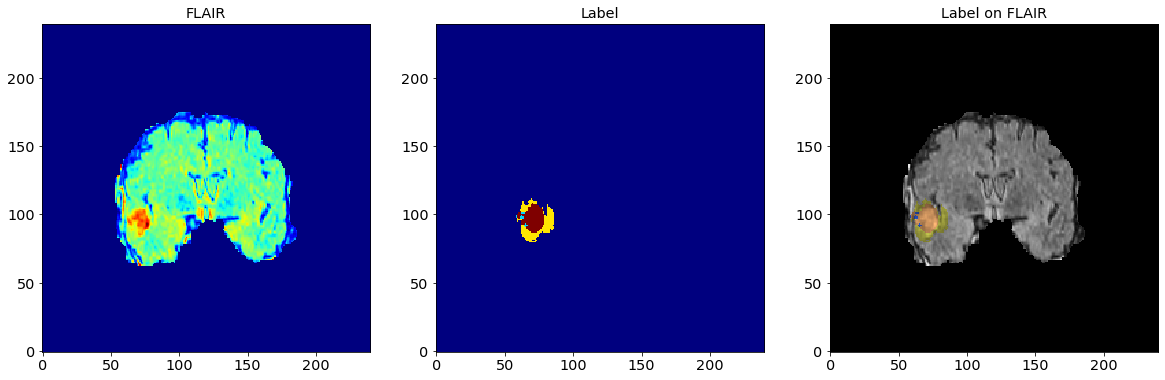

In [ ]:
i=6
show_img_lable(bimg[i], blbl[i])

# **Define Base Unet Model**

## **Build U-Net model**

In [ ]:
import tensorflow as tf
from keras import backend as K

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers import Input, UpSampling2D
from keras.layers.merge import concatenate, add

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [ ]:
IMG_HEIGHT = 240
IMG_WIDTH = 240
IMG_CHANNELS = 4

In [ ]:
from keras import backend as K 

# Do some code, e.g. train and save model

K.clear_session()

In [ ]:
dropout=0.2
hn = 'he_normal'
def unet(input_size = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)):
    
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv4)
    drop4 = Dropout(dropout)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = hn)(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = hn)(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = hn)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = hn)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv9)
    #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    
    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv9)
    
    model = Model(inputs = inputs, outputs = conv10)

    return model 

In [ ]:
model = unet(input_size = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS))

In [ ]:
model.compile(optimizer = Adam(lr = 0.0001), loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 240, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 240, 240, 64) 2368        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 240, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 120, 120, 64) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

In [ ]:
%%time
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

earlystopper = EarlyStopping(patience=8, verbose=1)
checkpointer = ModelCheckpoint(filepath = '/content/drive/My Drive/model_unet_4ch.hdf5',
                               verbose=1,
                               save_best_only=True, save_weights_only = True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.000001, verbose=1,  cooldown=1)

CPU times: user 103 µs, sys: 0 ns, total: 103 µs
Wall time: 108 µs


## **Training**

In [ ]:
history = model.fit_generator(gen_train_fast,
                              validation_data = gen_test_im, 
                              validation_steps=1,steps_per_epoch=30,
                              epochs=100,
                              callbacks=[checkpointer, reduce_lr])

In [ ]:
%%time
history = model.fit_generator(gen_train_fast,
                                        validation_data = gen_test_im, validation_steps=1,
                                              steps_per_epoch=30,
                              epochs=100,
                    callbacks=[earlystopper, checkpointer, reduce_lr])

*   Epoch 00018: val_loss did not improve from 0.03232
*   Epoch 00018: early stopping

In [ ]:
drow_history(history)

### Save weights after training

In [ ]:
model.save_weights('model_unet_ce.hdf5')

### Save model architecture + weights + workout setup + optimizer status

In [ ]:
model.save('/content/drive/My Drive/my_model.hdf5')

### Reload weights defined in checkpoint

In [ ]:
model.load_weights('model_unet_4ch.hdf5')

# **Predict with trained model**


> Function converts probabilities to labels



In [ ]:
def get_pred(img, threshold=0.5):
    out_img=img.copy()
    out_img=np.where(out_img>threshold, 1,0)
    return out_img

In [ ]:
def prediction_from_probabily_3D(img):
    
    int_image = get_pred(img)
    return lbl_from_cat(int_image)

In [ ]:
def get_prediction_for_batch(pred_batch, threshold=0.5):
    
    out_batch = np.zeros((pred_batch.shape[0], 240, 240),dtype=np.int)
    
    for j in range(pred_batch.shape[0]):
        pred = get_prediction(pred_batch[j])
        if (pred.sum()>0):
            print(j, np.unique(pred , return_counts=True))
        out_batch[j] = lbl_from_cat(get_prediction(pred_batch[j]))
    return out_batch

In [ ]:
def get_label_from_pred_batch(labels_batch):
    
    batch = np.zeros((labels_batch.shape[0], 240, 240), np.uint8)
     
    for j in range(labels_batch.shape[0]):
        batch[j]=get_pred(labels_batch[j,:,:,0])+\
                get_pred(labels_batch[j,:,:,1])*2+\
        get_pred(labels_batch[j,:,:,2])*4

    return batch

In [ ]:
def predict_3D_img_prob(np_file):
    
    np_img = np.load(np_file)
    for_pred_img = np.zeros((155, 240, 240, 4), np.float32)

    # Normalize image
    for_pred_img = normalize_3D_image(np_img)

    mdl_pred_img =  model.predict(for_pred_img)

    #pred_label = prediction_from_probabily_3D(mdl_pred_img)

    return mdl_pred_img

# **Predict on Test images**

In [ ]:
df_test.head()

In [ ]:
img_id = 'BraTS19_2013_18_1'
im,lb = get_numpy_img_lbl(img_id = 'BraTS19_2013_18_1')
im.shape,lb.shape

In [ ]:
nimg = os.path.join(NUMPY_DIR, img_id+'.npy')
pred_stats = predict_3D_img_prob(nimg)
pred_stats.shape

In [ ]:
pred = prediction_from_probabily_3D(pred_stats)
pred.shape

In [ ]:
np.unique(pred)


# **View predicted probabilities, and the resulted labels**

In [ ]:
ind=[70,80,90]
for i in ind:
    show_lable(pred_stats[i])
    show_lable(get_pred(pred_stats[i]))
    show_pred_im_lable(im[i], lb[i], pred[i])

# **Predict all test images to calculate IOU**

In [ ]:
TEST_PRED_NUMPY_DIR = '/naomi/DATA/predictions/pred1/test/numpy_images/'
VALIDATION_PRED_NUMPY_DIR = '/naomi/DATA/predictions/pred1/validation/numpy_images/'
VALIDATION_PRED_NII_DIR = '/naomi/DATA/predictions/pred1/validation/nii/'

### Check that its all working

In [ ]:
img_id = 'BraTS19_2013_18_1'
im,lb = get_numpy_img_lbl(img_id = 'BraTS19_2013_18_1')
im.shape,lb.shape

nimg = os.path.join(NUMPY_DIR, img_id+'.npy')
pred_stats = predict_3D_img_prob(nimg)
pred_stats.shape

pred = prediction_from_probabily_3D(pred_stats)
pred.shape

In [ ]:
for index, row in df_test.iterrows():

    img_id = row['id']
    im,lb = get_numpy_img_lbl(img_id = 'BraTS19_2013_18_1')

    nimg = os.path.join(NUMPY_DIR, img_id+'.npy')
    pred_stats = predict_3D_img_prob(nimg)

    pred = prediction_from_probabily_3D(pred_stats)

    out_img = os.path.join(TEST_PRED_NUMPY_DIR, img_id+'_pred.npy')

    np.save(out_img, pred)

# **Predict all validation image**

In [ ]:
df_val.head()

In [ ]:
img_id='BraTS19_TCIA13_616_1'
nimg = os.path.join(VALIDATION_NUMPY_DIR, img_id+'.npy')
im = np.load(nimg)
pred_stats = predict_3D_img_prob(nimg)
pred = prediction_from_probabily_3D(pred_stats)
show_pred_im(im[100], pred[100])

In [ ]:
for index, row in df_val.iterrows():

    img_id = row['id']

    nimg = os.path.join(VALIDATION_NUMPY_DIR, img_id+'.npy')
    pred_stats = predict_3D_img_prob(nimg)

    pred = prediction_from_probabily_3D(pred_stats)

    out_img = os.path.join(VALIDATION_PRED_NUMPY_DIR, img_id+'_pred.npy')
    np.save(out_img, pred)
    
    pred = np.where(pred==3,4, pred)
    out_nii = os.path.join(VALIDATION_PRED_NII_DIR, img_id+'.nii.gz')

    sitk_img = sitk.GetImageFromArray(pred)
    sitk.WriteImage(sitk_img , out_nii)